In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, shutil
sys.path.append('../../../fastai')

# this file contains all the main external libs used
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
DS_PATH = '../../../../_datasets/in-or-out'
# DS_PATH = '../../../datasets/in-or-out'

PATH = 'data/in-or-out'

# CLASSES = [ os.path.basename(d) for d in glob(os.path.join(DS_PATH, '*')) ]
CLASSES = ['in-n-out', 'not-in-n-out']

In [4]:
arch = resnet34
sz = 224
bsz = 10 #64

## 1. Data preparation

In [ ]:
shutil.rmtree(f'{DS_PATH}/train')
shutil.rmtree(f'{DS_PATH}/test')
shutil.rmtree(f'{DS_PATH}/valid')
shutil.rmtree(f'{DS_PATH}/sample')

In [ ]:
g = glob(f'{DS_PATH}/*/*')

for f in g:
    img = PIL.Image.open(f)
    if (img.mode == 'P' and img.format == 'PNG' and not f.endswith('.jpg')):
        img = scipy.misc.imread(f, mode='RGBA')
        img = PIL.Image.fromarray(img)
        img.save(f)


In [ ]:
# remove gif and jpegs with weird transparency settings
g = glob(f'{DS_PATH}/*/*')
for f in g:
    img = PIL.Image.open(f)
    if (img.mode == 'P'):
        os.remove(f)

### Create train, validation, test, and sample dirs

In [ ]:
for d in CLASSES:
    os.makedirs(f'{DS_PATH}/train/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/valid/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/sample/train/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/sample/valid/{d}', exist_ok=True)
    
os.makedirs(f'{DS_PATH}/sample/test/unknown', exist_ok=True)
os.makedirs(f'{DS_PATH}/test/unknown', exist_ok=True)

### Move training, validation, and test data into appropriate sub-dirs

In [ ]:
# COPY images into /train directory
for d in CLASSES:
    for f in os.listdir(f'{DS_PATH}/{d}'): 
        if (not f.startswith('.')): shutil.copyfile(f'{DS_PATH}/{d}/{f}', f'{DS_PATH}/train/{d}/{f}')

In [ ]:
# MOVE a subset of /train images into /valid
g = glob(f'{DS_PATH}/train/*/*')
n_valid = int(len(g) * 0.2)

shuf = np.random.permutation(g)
for i in range(n_valid): os.rename(shuf[i], shuf[i].replace('train', 'valid'))

### Copy a small subset of training data into /sample dir

In [ ]:
# COPY a small subset of each class into /sample
g = glob(f'{DS_PATH}/train/*/*')

shuf = np.random.permutation(g)
for i in range(100): shutil.copyfile(shuf[i], shuf[i].replace('train', 'sample/train'))
    
shuf = np.random.permutation(g)
for i in range(50): shutil.copyfile(shuf[i], shuf[i].replace('train', 'sample/valid'))

## 2. Configure paths

In [ ]:
os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

abs_ds_path = os.path.abspath(DS_PATH)

# symlink to root datasets so can use same data in other projects
!ln -s {abs_ds_path}/train {PATH}
!ln -s {abs_ds_path}/valid {PATH}
!ln -s {abs_ds_path}/test {PATH}
!ln -s {abs_ds_path}/sample {PATH}

## 3. Review Data

* TO DO

In [ ]:
g = glob(f'{PATH}/train/*/*')
size_d = {f: PIL.Image.open(f).size for f in g}

In [ ]:
row_sz, col_sz = list(zip(*size_d.values()))

In [ ]:
row_sz = np.array(row_sz); col_sz=np.array(col_sz)

In [ ]:
row_sz[:5]

In [ ]:
plt.hist(row_sz[row_sz<1000])
plt.show()
plt.hist(col_sz[col_sz<1000])
plt.show()

## 4. Training

**Review: easy steps to train a world-class image classifier:**
1. Enable data augmentation, and precompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [5]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}/tmp

In [6]:
# 1. Enable data augmentation, and precompute=True
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, bs=bsz, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 47/47 [00:05<00:00,  8.91it/s]


In [7]:
# 2. Use lr_find() to find highest learning rate where loss is still clearly improving
learn.lr_find()

A Jupyter Widget

 71%|███████   | 132/186 [00:01<00:00, 127.25it/s, loss=2.77] 


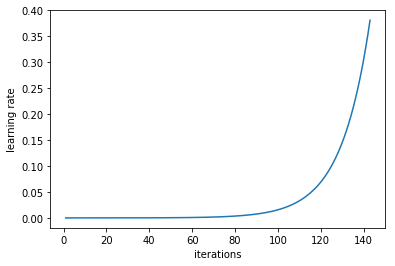

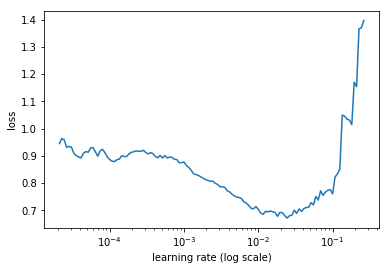

In [8]:
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

In [9]:
# 3. Train last layer from precomputed activations for 1-2 epochs
learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.       0.50338  0.35068  0.87872]                         
[ 1.       0.51313  0.62881  0.82908]                         



In [10]:
# 4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
learn.precompute = False
learn.fit(1e-2, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.4315   0.38123  0.90426]                        
[ 1.       0.32282  0.36195  0.89787]                        



In [11]:
learn.save('rn34_224_step4')

In [ ]:
# 5. Unfreeze all layers
learn.unfreeze()

In [ ]:
# 6. Set earlier layers to 3x-10x lower learning rate than next higher layer
lr = np.array([1e-7, 1e-6, 1e-5])

In [ ]:
lr/1000

In [ ]:
learn.lr_find(lr/1000)
learn.sched.plot()

In [ ]:
# 8. Train full network with cycle_mult=2 until over-fitting
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('rn34_224_step8')

In [ ]:
log_preds, y = learn.TTA()
accuracy(log_preds, y)

## Analyzing Results

In [ ]:
from sklearn.metrics import confusion_matrix

preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [ ]:
log_preds = learn.predict()
log_preds.shape, data.classes

In [ ]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1]) # pr pred == 1 (probability that it IS NOT an In-N-Out burger)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([ data.val_ds[idx][0] for idx in idxs ])
    img_titles = [ probs[idx] for idx in idxs ]
    #img_titles = [ data.val_ds.fnames[ix] for ix in idxs ]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=img_titles)

In [ ]:
def rand_idxs_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_idxs_by_correct(is_correct):
    return rand_idxs_by_mask((preds == data.val_y) == is_correct)

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_idxs_by_correct(True), 'Correctly Classified')

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_idxs_by_correct(False), 'Incorrectly Classified')

In [ ]:
def idxs_most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [ ]:
mask = (data.val_y == 0) & (preds == data.val_y)

plot_val_with_title(idxs_most_by_mask(mask, 1), "Most Correct In-N-Out Burgers")

In [ ]:
mask = (data.val_y == 1) & (preds == data.val_y)

plot_val_with_title(idxs_most_by_mask(mask,-1), "Most Correct NOT In-N-Out Burgers")

In [ ]:
mask = (data.val_y == 0) & (preds != data.val_y)

plot_val_with_title(idxs_most_by_mask(mask, -1), "Most Incorrect In-N-Out Burgers")

In [ ]:
mask = (data.val_y == 1) & (preds != data.val_y)

plot_val_with_title(idxs_most_by_mask(mask, 1), "Most Incorrect NOT In-N-Out Burgers")

In [12]:
learn.load('rn34_224_step4')

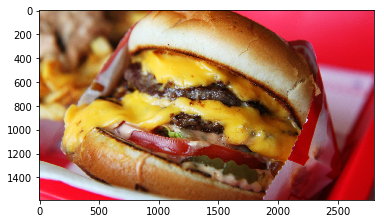

In [13]:
img = PIL.Image.open(f'{PATH}/valid/in-n-out/2.jpg')
plt.imshow(img)

In [18]:
trn_tfms, val_tfrms = tfms_from_model(arch, sz)
im = val_tfrms(Image.open(f'{PATH}/valid/in-n-out/5.jpg'))

log_probs = to_np(learn.models.model(V(T(im[None]).cuda())))
preds = np.argmax(log_probs, axis=1)

log_probs, preds

(array([[-0.02428, -3.73008]], dtype=float32), array([0]))

In [37]:
torch_model = learn.models.model
img = Image.open(f'{PATH}/valid/in-n-out/316.jpg')

normalize = torchvision.transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Scale(256),
   torchvision.transforms.CenterCrop(224),
   torchvision.transforms.ToTensor(),
   normalize
])

img_tensor = preprocess(img).unsqueeze_(0)
img_variable = Variable(img_tensor.cuda())

log_probs = torch_model(img_variable).cpu().data.numpy()
preds = np.argmax(log_probs, axis=1)

print(log_probs, preds)

[[-9.33196 -0.00009]] [1]


In [ ]:
fc_out